<a href="https://colab.research.google.com/github/Bitang-Melyen-Tanulok/Csip_Csip/blob/main/Cross_valid_Train_Uj_Uj_Uj_mentessel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We needed to check if there is any duplication of titles or audio files among the data.

If there was, we would then remove them from the database, only keeping the first appearance.


In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/DeepLearning'
spectrograms_path = os.path.join(base_path, 'ugyanaz?')  # Directory for spectrogram files

import hashlib
import shutil

import os
import hashlib

X = []
Y = []

def get_file_hash(file_path):
    hash_md5 = hashlib.md5()  # Create an MD5 hash object to store the file's hash value
    with open(file_path, "rb") as f:
        # Read the file in chunks (4KB at a time) and update the hash
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()  # Return the final hash value as a hexadecimal string

def delete_duplicates_and_log(spectrograms_path):
    global X,Y
    seen_hashes = set()  # This will store the hashes of files we've already processed
    files_to_delete = []  # List to track files that are duplicates and will be deleted
    files_to_keep = []  # List to track files that are unique and will be kept

    # Walk through the folders in the spectrograms directory
    for folder in os.listdir(spectrograms_path):
        folder_path = os.path.join(spectrograms_path, folder)

        # Loop through the files in the current folder
        files = os.listdir(folder_path)
        for file in files:
            if file.endswith('.png'):  # We're only interested in .png files (spectrograms)
                file_path = os.path.join(folder_path, file)

                # Generate a hash for the file to compare it with others
                file_hash = get_file_hash(file_path)

                if file_hash in seen_hashes:
                    # If we've already seen this hash, it's a duplicate
                    #print(f"Duplicate file found: {file_path}")
                    files_to_delete.append(file_path)
                else:
                    # If we haven't seen this hash yet, add it to the seen set and keep it
                    seen_hashes.add(file_hash)
                    files_to_keep.append(file_path)

                    img = image.load_img(file_path, color_mode="rgb")
                    img_array = image.img_to_array(img)
                    X.append(img_array)
                    Y.append(folder)

    # Log files that we kept (not duplicates)
    '''
    print("Files kept:")
    for file_path in files_to_keep:
        print(f"   - Keeping file: {file_path}")
    '''

    # Log files that we deleted (duplicates)
    print("\nFiles deleted:")
    for file_path in files_to_delete:
        print(f"   - Deleting file: {file_path}")
        os.remove(file_path)  # Actually delete the duplicate files

    # Convert X and Y to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Shuffle the data
    permutation = np.random.permutation(len(X))
    X = X[permutation]
    Y = Y[permutation]

    # Print shapes of the arrays
    print(f"\nX shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    return X, Y

X, Y = delete_duplicates_and_log(spectrograms_path)

Mounted at /content/drive

Files deleted:

X shape: (1769, 128, 313, 3)
Y shape: (1769,)


Since this is a multi-class classification task, I am converting labels to one-hot format:

In [2]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#First, the labels need to be converted into numerical values
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

#Getting number of classes
num_classes = len(le.classes_)
print(f"Class number= {num_classes}")

#Converting to one-hot encoding
Y_onehot = to_categorical(Y_encoded, num_classes)

Class number= 20


We implemented early stopping, in case the model started overfitting.

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

#Implementing early stopping, since there is no reason for it to learn further when val_loss isn't decreasing
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, #If it doesn't improve for 10 epochs, it concludes
    verbose=1,
    restore_best_weights=True
)

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint # Importing the missing ModelCheckpoint class

checkpoint_dir = '/content/drive/MyDrive/DeepLearning/checkpoints_sample'
os.makedirs(checkpoint_dir, exist_ok=True)

#checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras')
checkpoint_path = os.path.join(checkpoint_dir, 'model_latest.keras')
epoch_info_path = os.path.join(checkpoint_dir, 'epoch_info.npy')

#Saving the latest model at each epoch, so that if colab collapses, we don't have to start from zero
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    verbose=1
)

In [5]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00


We used efficientNetV2 pretrained model, since most kaggle teams suggested it.

In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# Enable XLA compilation for faster execution
# tf.config.optimizer.set_jit(True)

# Setting up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Implementing mixed precision training for faster outcomes
mixed_precision.set_global_policy('mixed_float16')

# Setting up learning rate sceduler - reduces learning rat if the model stops improving
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=3,
#     verbose=1,
#     min_lr=1e-6
# )

fold_accuracies = []
fold_losses = []
history_per_fold = []

last_completed_epoch = 0
if os.path.exists(epoch_info_path) and os.path.exists(checkpoint_path):
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    last_completed_epoch = int(np.load(epoch_info_path))
    print(f"Resuming from epoch {last_completed_epoch}")
else:
  print("No epoch info file found. Starting from scratch.")

# Starting K-Fold
fold_number = 1
for train_index, valid_index in skf.split(X, Y_encoded):
    print(f"Starting fold: {fold_number}")

    # Splitting the data into training and validation sets
    X_train, X_valid = X[train_index], X[valid_index]
    Y_train, Y_valid = Y_onehot[train_index], Y_onehot[valid_index]

    # Normalizing the data
    X_train = preprocess_input(X_train)
    X_valid = preprocess_input(X_valid)

    # Setting the input shape based on the data
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
      print(f"Loading latest checkpoint: {latest_checkpoint}")
      model = load_model(latest_checkpoint)
    else:
      print("No checkpoint found. Building new model.")

      # Loading the pre-trained EfficientNetV2B0 model
      base_model = EfficientNetV2B0(
          include_top=False,
          weights='imagenet',
          input_shape=input_shape
      )

      # Defining a new model
      model = models.Sequential()

      # Freezing the base model layers if we don't want to update them during training
      base_model.trainable = False

      # Adding the pre-trained model
      model.add(base_model)
      model.add(layers.GlobalAveragePooling2D())  # Selecting the best representations

      # Adding Dense layers
      model.add(layers.Dense(128, activation='relu')) #128
      model.add(layers.BatchNormalization())
      model.add(layers.Dropout(0.4))  # Adding Dropout to prevent overfitting
      model.add(layers.Dense(num_classes, activation='softmax'))

      # Compiling the model
      model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model.fit(
        X_train, Y_train,
        initial_epoch=last_completed_epoch,
        epochs=20,
        batch_size=128, # try larger throughput 128, 256, original is 64
        validation_data=(X_valid, Y_valid),
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Save the last completed epoch
    last_completed_epoch += len(history.epoch)
    np.save(epoch_info_path, last_completed_epoch)

    # Fine-tuning the last 10 layers
    base_model.trainable = False
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy']) # low learning rate

    fine_tuning_history = model.fit(
        X_train, Y_train,
        epochs=5,
        batch_size=128,
        validation_data=(X_valid, Y_valid),
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Saving the results
    final_model_path = os.path.join(checkpoint_dir, f'final_model_fold_{fold_number}.keras')
    model.save(final_model_path)

    valid_loss, valid_accuracy = model.evaluate(X_valid, Y_valid)

    fold_accuracies.append(valid_accuracy)
    fold_losses.append(valid_loss)
    history_per_fold.append(history)

    fold_number += 1

# Summary of the final model
model.summary()

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Resuming from epoch 20
Starting fold: 1
No checkpoint found. Building new model.
24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/5
12/12 [==============================] - ETA: 0s - loss: 4.1460 - accuracy: 0.0565 
Epoch 1: saving model to /content/drive/MyDrive/DeepLearning/checkpoints_sample/model_latest.keras
12/12 [==============================] - 156s 12s/step - loss: 4.1460 - accuracy: 0.0565 - val_loss: 2.9176 - val_accuracy: 0.1215
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 4.0412 - accuracy: 0.0565 
Epoch 2: saving model to /content/drive/MyDrive/DeepLearning/checkpoints_sample/model_latest.keras
12/12 [==============================] - 142s 12s/step - loss: 4.0412 - accuracy: 0.0565 - val_loss: 2.9197 - val_accuracy: 0.1158
Epoch 3/5
12/12 [==============================] - ETA: 0s - loss: 4.0838 - accuracy: 0.0594 
Epoch 3: saving model to /content/drive/MyDrive/DeepLearning/checkpoints_sample/model_latest.keras
12/12 [======

In [7]:
print("\nCross-Validation Results:")
print(f"Mean Validation Loss: {np.mean(fold_losses)}")
print(f"Mean Validation Accuracy: {np.mean(fold_accuracies)}")

for i, (loss, accuracy) in enumerate(zip(fold_losses, fold_accuracies), start=1):
    print(f"Fold {i} - Validation Loss: {loss}, Validation Accuracy: {accuracy}")


Cross-Validation Results:
Mean Validation Loss: 3.003914546966553
Mean Validation Accuracy: 0.0768697690218687
Fold 1 - Validation Loss: 2.9128596782684326, Validation Accuracy: 0.10734463483095169
Fold 2 - Validation Loss: 2.9619085788726807, Validation Accuracy: 0.12711864709854126
Fold 3 - Validation Loss: 3.1665894985198975, Validation Accuracy: 0.01977401040494442
Fold 4 - Validation Loss: 2.9850149154663086, Validation Accuracy: 0.07062146812677383
Fold 5 - Validation Loss: 2.9932000637054443, Validation Accuracy: 0.059490084648132324


KeyError: 'accuracy'

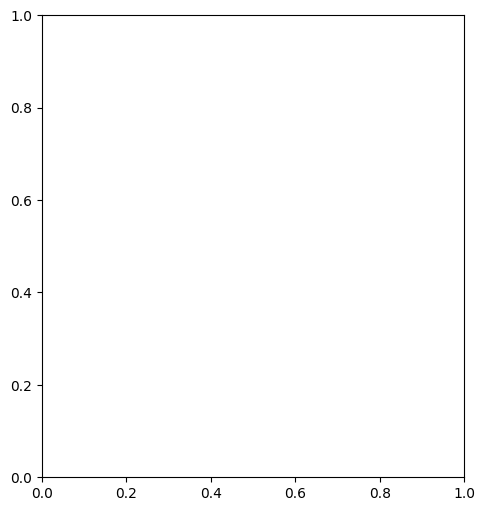

In [8]:
import matplotlib.pyplot as plt

# Plot loss and accuracy for each fold
for i, history in enumerate(history_per_fold):
  plt.figure(figsize=(12, 6))

  # Plot accuracy
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'Fold {i + 1} Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Fold {i + 1} Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()